___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

___
## Parsing predownloaded pbf maps

In [3]:
import geopandas
from pyrosm import OSM

/home/denis/.local/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

In [4]:
minx = 37.3
miny = 55.535
maxx = 37.375
maxy = 55.57
bbox_width = maxx - minx
bbox_length = maxy - miny

<AxesSubplot:>

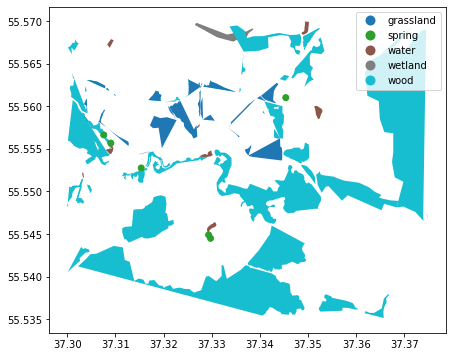

In [5]:
osm = OSM("maps/valuevo.osm.pbf", bounding_box=[minx, miny, maxx, maxy])
# custom_filter = {"natural" : True}
# natural = osm.get_data_by_custom_criteria(custom_filter = custom_filter, keep_nodes = True)
natural = osm.get_natural(extra_attributes=['nodes'])
natural.plot(column='natural', legend=True, figsize=(10,6))
# print("\nAdditional attributes in the 'tags': \n", natural.tags.unique())

In [6]:
natural.tail(2)

,timestamp,version,id,lon,changeset,lat,tags,natural,geometry,osm_type,water
48,0,-1,401152219,NaN,0.0,NaN,"{""type"":""multipolygon""}",wood,"POLYGON ((37.30295 55.55929, 37.30841 55.55452...",relation,None
49,0,-1,1422051155,NaN,0.0,NaN,"{""type"":""multipolygon""}",wood,"POLYGON ((37.36487 55.56605, 37.36822 55.56717...",relation,None


In [7]:
natural.geometry.type.unique()

array(['Point', 'Polygon', 'MultiPolygon'], dtype=object)

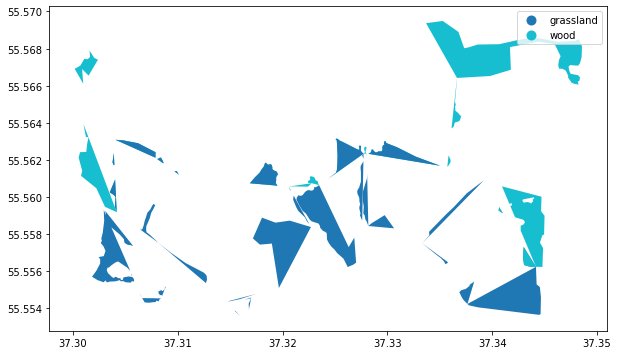

In [8]:
multipolygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'MultiPolygon']
multipolygons.plot(column='natural', legend=True, figsize=(10,6));

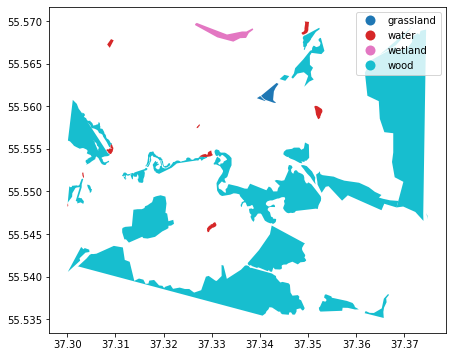

In [9]:
polygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'Polygon']
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Building a convex hull

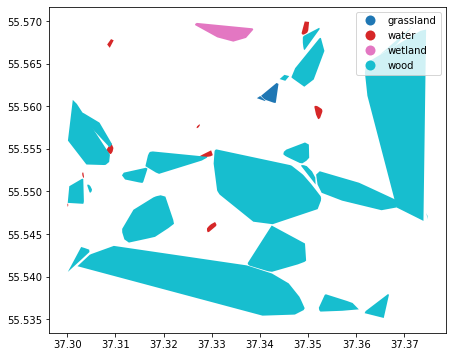

In [10]:
polygons.geometry = polygons.geometry.convex_hull # check for efficiency and rewrite if needed
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Find optimal pair

In [11]:
import numpy as np
import math

def vec(a, b):
    return np.array(b) - np.array(a)

def mod(v):
    return (v[0]**2 + v[1]**2)**0.5

def angle(a, b, c):
    if type(a == b) != bool and ((a == b).all() or (a == c).all() or (b == c).all()):
        return 1
    cos = np.dot(vec(b,a), vec(b,c)) / (mod(vec(b, a)) * mod(vec(b, c)))
    if math.fabs(cos) > 1:
        return 1
    return math.acos(cos)

def point_in_angle(p, a, b, c):
    delta = 0.00000001
    return math.fabs(angle(a, b, c) - angle (a, b, p) - angle(p, b, c)) < delta

In [12]:
def find_pair(point, left_border, right_border, coord):
    n = len(coord) - 1
    # optimize list work
    b = [1 for i in range(n)]
    count = 0
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            b[i] = 0
            count += 1
    if count == 0:
        return 1, 1
    if count == n:
        # print("Point inside a polygon")
        return 1, 1
    if b[0] == 1:
        start = b.index(0, 1)
        if b[n-1] == 0:
            end = n-1
        else:
            end = b.index(1, start + 1)
            end -= 1
    if b[0] == 0:
        start = b.index(1, 1)
        start -= 1
        if b[n-1] == 1:
            end = n
        else:
            end = b.index(0, start + 1)
    return start, end

In [13]:
def find_pair2(point, left_border, right_border, coord):
    n = len(coord) - 1
    begin = end = -1
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            if i == 0:
                start_zero = True
            if begin == -1 and not start_zero:
                begin = i
            if start_zero and end != -1:
                begin = i
                return min(begin, end), max(begin, end)
            if not start_zero and i == n - 1:
                end = n - 1
                return min(begin, end), max(begin, end)
        else:
            if i == 0:
                start_zero = False
            if begin != -1 and not start_zero:
                end = (i-1)%n
                return min(begin, end), max(begin, end)
            if start_zero and end == -1:
                end = (i-1)%n
            if start_zero and i == n - 1:
                begin = n
                return min(begin, end), max(begin, end)
    return 1, 1

___
## Build a graph

In [14]:
from shapely.geometry import Polygon, mapping, MultiPolygon
import matplotlib.pyplot as plt
import mplleaflet
import networkx as nx

In [15]:
epsilon = 0.001
bbox_comp = 25
def check_bounds(poly):
    bounds = poly.bounds
    return bbox_width / (bounds[2] - bounds[0]) <= bbox_comp and bbox_length / (bounds[3] - bounds[1]) <= bbox_comp

In [16]:
import pandas as pd
import rdp

def get_coord(poly):
    if bbox_comp is not None and not check_bounds(poly):
        return 0
    return rdp.rdp(np.array(mapping(poly)['coordinates'][0]), epsilon=epsilon)

def get_centroid(poly):
    return Polygon(poly).centroid

data = pd.DataFrame(polygons)
data['centroid'] = data.geometry.apply(get_centroid)
data.geometry = data.geometry.apply(get_coord)
data = data.reset_index().rename(columns={'geometry' : 'coords'}).drop(columns='index')
data.head()

,natural,coords,centroid
0,water,0,POINT (37.35213303704695 55.55934500506783)
1,water,0,POINT (37.32907439781264 55.55432921107081)
2,water,0,POINT (37.33117245331348 55.55447946161383)
3,wood,"[[37.3128106, 55.5439975], [37.3114164, 55.545...",POINT (37.31686300764323 55.54661554095011)
4,wood,"[[37.3033187, 55.5485486], [37.3001183, 55.548...",POINT (37.30195923808738 55.54982909893218)


In [17]:
multipolygons = pd.DataFrame(multipolygons)

for i in range(multipolygons.shape[0]):
    multi_natural = multipolygons.natural.iloc[i]
    for polygon in MultiPolygon(multipolygons.geometry.iloc[i]).geoms:
        poly = polygon.convex_hull
        if bbox_comp is not None and not check_bounds(poly):
            coords = 0
        else: 
            coords = rdp.rdp(np.array(mapping(poly)['coordinates'][0]), epsilon = epsilon)
        data = data.append({'coords': coords,
                            'natural': multi_natural,
                            'centroid': poly.centroid}, ignore_index=True)

data.head()

,natural,coords,centroid
0,water,0,POINT (37.35213303704695 55.55934500506783)
1,water,0,POINT (37.32907439781264 55.55432921107081)
2,water,0,POINT (37.33117245331348 55.55447946161383)
3,wood,"[[37.3128106, 55.5439975], [37.3114164, 55.545...",POINT (37.31686300764323 55.54661554095011)
4,wood,"[[37.3033187, 55.5485486], [37.3001183, 55.548...",POINT (37.30195923808738 55.54982909893218)


In [18]:
def build_graph(polygons, plot=False, view_angle=None, use_centroid=False):
    poly_number = polygons.shape[0]
    fig = plt.figure()
    G = nx.MultiGraph(crs='EPSG:4326')
    max_poly_len = 10000 # for graph indexing

    for i in range(poly_number):

        coords_1 = polygons.coords[i]
        if type(coords_1) == int:
            continue
        
        n = len(coords_1) - 1
        for k in range(n):
            point = coords_1[k]
            left_border = coords_1[(k-1)%n]
            right_border = coords_1[(k+1)%n]
            G.add_node(i * max_poly_len + k, x=point[0], y=point[1])
            
            if view_angle is None or view_angle == 0:
                view_angle_std = 1
            else:
                view_angle_std = view_angle
            angle_count = math.floor(360 / view_angle_std)
            crosses = [None for p in range(angle_count)]
        
            for j in range(poly_number):

                if j == i:
                    for t in range (n):
                        if t == k:
                            continue
                        other_point = coords_1[t]
                        G.add_node(i * max_poly_len + t, x=other_point[0], y=other_point[1])
                        G.add_edge(i * max_poly_len + t, i * max_poly_len + k)
                        if plot:
                            plt.plot([point[0], other_point[0]], [point[1], other_point[1]])
                    continue

                coords_2 = polygons.coords[j]
                if type(coords_2) == int:
                    continue

                left, right = find_pair(point, left_border, right_border, coords_2)
                if left == 1:
                    continue
                left_coords = coords_2[left]
                right_coords = coords_2[right]

                if view_angle is not None:
                    delta_angle = view_angle * math.pi / 180
                    if angle(left_coords, point, right_coords) < delta_angle:
                        if use_centroid:
                            x = polygons.centroid[j].x
                            y = polygons.centroid[j].y
                            x_rel = x - point[0]
                            y_rel = y - point[1]
                            dist = mod((x_rel, y_rel))
                            k1 = math.ceil(math.atan2(y_rel, x_rel) * 180 / math.pi / view_angle_std)
                            if crosses[k1] is None or crosses[k1][0] > dist:
                                crosses[k1] = [dist, [x, y]]
                        continue

                x1 = left_coords[0]
                x2 = right_coords[0]
                y1 = left_coords[1]
                y2 = right_coords[1]
                x1_rel = x1 - point[0]
                y1_rel = y1 - point[1]
                x2_rel = x2 - point[0]
                y2_rel = y2 - point[1]
                dist1 = mod((x1_rel, y1_rel))
                dist2 = mod((x2_rel, y2_rel))
                k1 = math.ceil(math.atan2(y1_rel, x1_rel) * 180 / math.pi / view_angle_std)
                k2 = math.ceil(math.atan2(y2_rel, x2_rel) * 180 / math.pi / view_angle_std)
                if crosses[k1] is None or crosses[k1][0] > dist1:
                    crosses[k1] = [dist1, [x1, y1]]
                if crosses[k2] is None or crosses[k2][0] > dist2:
                    crosses[k2] = [dist2, [x2, y2]]
                for p in range(min(k1, k2) + 1, max(k1, k2)):
                    k_curr = math.tan((p * view_angle_std + 0.00001)*math.pi/180)
                    if x1_rel == x2_rel:
                        k_segment = 100000
                    else:
                        k_segment = (y1_rel - y2_rel) / (x1_rel - x2_rel)
                    b_segment = y1_rel - k_segment * x1_rel
                    x = b_segment / (k_curr - k_segment)
                    y = k_curr * x
                    if not point_in_angle((x, y), (x1_rel, y1_rel), (0, 0), (x2_rel, y2_rel)):
                        continue
                    dist = mod((x, y))
                    if crosses[p] is None or crosses[p][0] > dist:
                        crosses[p] = [dist, None]

            for p in range(angle_count):
                if crosses[p] is not None and crosses[p][1] is not None:
                    G.add_node(i * 2 * max_poly_len + p, x = crosses[p][1][0], y = crosses[p][1][1])
                    G.add_edge(i * 2 * max_poly_len + p, i * max_poly_len + k)
                    if plot:
                        plt.plot([point[0], crosses[p][1][0]], [point[1], crosses[p][1][1]]);

    return G, fig

In [19]:
%%time
view_angle = 5
G, fig = build_graph(data, plot=False, view_angle=view_angle, use_centroid=False)
# mplleaflet.display(fig=fig)

CPU times: user 3.7 s, sys: 66.8 ms, total: 3.76 s
Wall time: 4.2 s


<Figure size 432x288 with 0 Axes>

In [20]:
G.number_of_edges()

1151

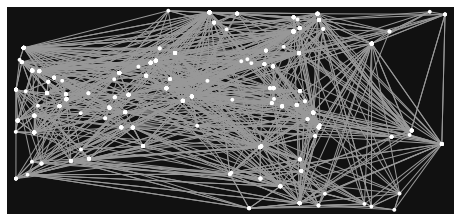

In [21]:
import osmnx as ox
ox.plot_graph(G);

___
Problems:
- Possibly slow convex hull
- LineString not computed
- How to store graph